In [7]:
using SCYFI
using CSV, DataFrames, Statistics, Plots, NPZ
using LinearAlgebra
#using StatsBase
#

In [8]:
"""
return the outer and inner loop iterations once the first cycle is found!
"""
function scy_fi(
    A:: Array, W:: Array, h:: Array, order:: Integer, found_lower_orders:: Array;
    outer_loop_iterations:: Union{Integer,Nothing}= nothing,
    inner_loop_iterations:: Union{Integer,Nothing} = nothing
     )
    dim = size(A)[1]
    cycles_found = Array[]
    eigvals =  Array[]
    outer_loop_iterations, inner_loop_iterations = set_loop_iterations(order, outer_loop_iterations, inner_loop_iterations)
    i = -1
    while i < outer_loop_iterations
        i += 1
        relu_matrix_list = construct_relu_matrix_list(dim, order)
        difference_relu_matrices = 1
        c = 0
        while c < inner_loop_iterations
            c += 1
            z_candidate = get_cycle_point_candidate(A, W, relu_matrix_list, h, order)
            if z_candidate !== nothing
                trajectory = get_latent_time_series(order, A, W, h, dim, z_0=z_candidate)
                trajectory_relu_matrix_list = Array{Bool}(undef, dim, dim, order)
                for j = 1:order
                    trajectory_relu_matrix_list[:,:,j] = Diagonal(trajectory[j].>0)
                end
                for j = 1:order
                    difference_relu_matrices = sum(abs.(trajectory_relu_matrix_list[:,:,j].-relu_matrix_list[:,:,j]))
                    if difference_relu_matrices != 0
                        break
                    end
                    if !isempty(found_lower_orders)
                        if map(temp -> round.(temp, digits=2), trajectory[1]) ∈ map(temp -> round.(temp,digits=2),collect(Iterators.flatten(Iterators.flatten(found_lower_orders))))
                            difference_relu_matrices = 1
                            break
                        end
                    end
                end
                if difference_relu_matrices == 0
                    if map(temp1 -> round.(temp1, digits=2), trajectory[1]) ∉ map(temp -> round.(temp, digits=2), collect(Iterators.flatten(cycles_found)))
                        e = get_eigvals(A,W,relu_matrix_list,order)
                        push!(cycles_found,trajectory)
                        push!(eigvals,e)
                        i=0
                        c=0
                    end
                end
                if relu_matrix_list == trajectory_relu_matrix_list
                    relu_matrix_list = construct_relu_matrix_list(dim, order)
                else
                    relu_matrix_list = trajectory_relu_matrix_list
                end
            else
                relu_matrix_list = construct_relu_matrix_list(dim, order)
            end 
        end
    end
    return cycles_found, eigvals
end

function create_grid_data(
    A::Array,
    W::Array,
    h::Array,
    param_changed_1::String,
    param_1::Array,
    )
    data_list = Array[]
    for i = 1:length(param_1)
        A₁ = A
        W₁ = W
        h₁ = h
        if param_changed_1 == "a11"
            A₁ = A₁ + [[param_1[i] 0]; [0 0]]
            W₁ = W₁ + [[-param_1[i] 0]; [0 0]]
        end
        push!(data_list,[A₁,W₁,h₁])
    end
    return data_list
end

function main(
    A:: Array, W:: Array, h:: Array, order:: Integer;
    outer_loop_iterations:: Union{Integer,Nothing}= nothing,
    inner_loop_iterations:: Union{Integer,Nothing} = nothing
     )
    found_lower_orders = Array[]
    found_eigvals = Array[]
     
    for i =1:order
        cycles_found, eigvals = scy_fi(A, W, h, i, found_lower_orders, outer_loop_iterations=outer_loop_iterations,inner_loop_iterations=inner_loop_iterations)
     
        push!(found_lower_orders,cycles_found)
        push!(found_eigvals,eigvals)
    end
    return [found_lower_orders, found_eigvals]
end

function main_grid(
    A::Array,
    W::Array,
    h::Array,
    order::Integer,
    param_changed_1::String,
    param_1::Array,
    filepath::String ="result/system_001_res.pkl",
    filepath_img::String="result/system_001_res"
    )
    #hdf5()
    println("starting calculation")
    println("Using ", Threads.nthreads()," threats")
    data_list =  create_grid_data(A,W,h,param_changed_1,param_1)
    result = fill([],length(data_list)) 
    
    for i in eachindex(data_list)
        result[i] = main(data_list[i][1],data_list[i][2],data_list[i][3],order)
    end
    #@time begin
    #    df = convert_data_to_dataframe(A,W,h,result,order,param_1,param_2)
    #end
    #CSV.write(filepath, df)
    #println("starting plotting")
    #h = find_bifurcations_parameter_grid(df)
    #display(h)
    #Plots.hdf5plot_write(h, filepath_img * ".hdf5")
    #savefig(filepath_img * ".png")
    

    return result
end

main_grid (generic function with 3 methods)

In [9]:

a11 = 0.
a22 = 0.2
a21 = -0.4
a12 = 0.8
w12 = 0.
w21 = 0.9
w11 = -1.5
w22 = 0.
h1 = 0.214
h2 = 0.
        
bl=a21
c=a12
d=a22
br=w21+a21


A = [[a11 a12]; [a21 a22]]
W = [[w11 w12]; [w21 w22]]
h = [[h1]; [h2]]
ar = ones(101)*-1.5
al = -0.48:0.0098:0.5

res=main_grid(A,W,h,2,"a11",[-0.48:0.98/24:0.5;])


starting calculation
Using 1 threats

25-element Vector{Vector{Any}}:
 [Array[Array[Array[[0.107, 0.066875]]], Array[Array[[50.504000000002264, 27.552500000001245], [-53.5000000000024, 30.76250000000138]]]], Array[Array[[-1.7094810050208544, 0.4094810050208546]], Array[[-0.1572347875864725, 0.9972347875864724]]]]
 [Array[Array[Array[[0.107, 0.066875]]], Array[Array[[2.8944653802497076, 1.5160357548240588], [-2.9148694665153143, 1.7504398410896655]]]], Array[Array[[-1.7094810050208544, 0.4094810050208546]], Array[[-0.17109761957357622, 0.9498476195735759]]]]
 [Array[Array[Array[[0.107, 0.066875]]], Array[Array[[1.5611761960326713, 0.7868932322053672], [-1.498249708284713, 0.937966744457409]]]], Array[Array[[-1.7094810050208544, 0.4094810050208546]], Array[[-0.18616732935678726, 0.903667329356787]]]]
 [Array[Array[Array[[0.107, 0.066875]]], Array[Array[[1.0999952885747943, 0.5346849234393407], [-1.0082449941107192, 0.6569346289752653]]]], Array[Array[[-1.7094810050208544, 0.4094810050208546]], Array[[-0.2025500565317726, 0.8

In [10]:
res[4][2][2][1][1]

#es[i][1][2][1][1][1]]

-0.2025500565317726

In [11]:
# 2 .-cycle defined by:
a11 = 0.
a22 = 0.2
a21 = -0.4
a12 = 0.8
w12 = 0.
w21 = 0.9
w11 = -2.
w22 = 0.
h1 = 0.214
h2 = 0.
        
bl=a21
c=a12
d=a22
br=w21+a21

ar = ones(101)*-1.5
al = -0.48:0.0098:0.5

x11=(((1 .-d) .*h1 .+c .*h2) .*(al .+d .+al .*d .-bl .*c .+1)) ./((ar .*d .-br .*c) .*(al .*d .-bl .*c) .-c .*(bl .+br) .-d .^2 .-al .*ar .+1)
x12=(h2 .*(1 .+d .-al .*ar .-br .*c .-al .*ar .*d .+ar .*bl .*c) .+h1 .*(bl .+ar .*bl .+br .*d .+al .*br .*d .-bl .*br .*c)) ./((ar .*d .-br .*c) .*(al .*d .-bl .*c) .-c .*(bl .+br) .-d .^2 .-al .*ar .+1)

x21=(((1 .-d) .*h1 .+c .*h2) .*(ar .+d .+ar .*d .-br .*c .+1)) ./((ar .*d .-br .*c) .*(al .*d .-bl .*c) .-c .*(bl .+br) .-d .^2 .-al .*ar .+1)
x22=((h2 .*(1 .+d .-al .*ar .-bl .*c .-al .*ar .*d .+al .*br .*c) .+h1 .*(br .+al .*br .+bl .*d .+ar .*bl .*d .-bl .*br .*c))) ./((ar .*d .-br .*c) .*(al .*d .-bl .*c) .-c .*(bl .+br) .-d .^2 .-al .*ar .+1)

101-element Vector{Float64}:
 30.76250000000019
  6.019397386253677
  3.367403536977505
  2.3523944053353096
  1.8161523216308075
  1.4845790378006871
  1.2592776067718368
  1.0962133145415365
  0.9727272727272736
  0.8759695335845139
  ⋮
  0.15854482273934095
  0.15768823468822826
  0.15684982548215337
  0.15602902249952733
  0.15522527691847124
  0.15443806249305567
  0.15366687440428184
  0.15291122818053154
  0.15217065868263474

In [12]:
x11=(((1 .-d) .*h1 .+c .*h2) .*(al .+d .+al .*d .-bl .*c .+1)) ./((ar .*d .-br .*c) .*(al .*d .-bl .*c) .-c .*(bl .+br) .-d .^2 .-al .*ar .+1)
x12=(h2 .*(1 .+d .-al .*ar .-br .*c .-al .*ar .*d .+ar .*bl .*c) .+h1 .*(bl .+ar .*bl .+br .*d .+al .*br .*d .-bl .*br .*c)) ./((ar .*d .-br .*c) .*(al .*d .-bl .*c) .-c .*(bl .+br) .-d .^2 .-al .*ar .+1)

x21=(((1 .-d) .*h1 .+c .*h2) .*(ar .+d .+ar .*d .-br .*c .+1)) ./((ar .*d .-br .*c) .*(al .*d .-bl .*c) .-c .*(bl .+br) .-d .^2 .-al .*ar .+1)
x22=((h2 .*(1 .+d .-al .*ar .-bl .*c .-al .*ar .*d .+al .*br .*c) .+h1 .*(br .+al .*br .+bl .*d .+ar .*bl .*d .-bl .*br .*c))) ./((ar .*d .-br .*c) .*(al .*d .-bl .*c) .-c .*(bl .+br) .-d .^2 .-al .*ar .+1)


101-element Vector{Float64}:
 30.76250000000019
  6.019397386253677
  3.367403536977505
  2.3523944053353096
  1.8161523216308075
  1.4845790378006871
  1.2592776067718368
  1.0962133145415365
  0.9727272727272736
  0.8759695335845139
  ⋮
  0.15854482273934095
  0.15768823468822826
  0.15684982548215337
  0.15602902249952733
  0.15522527691847124
  0.15443806249305567
  0.15366687440428184
  0.15291122818053154
  0.15217065868263474

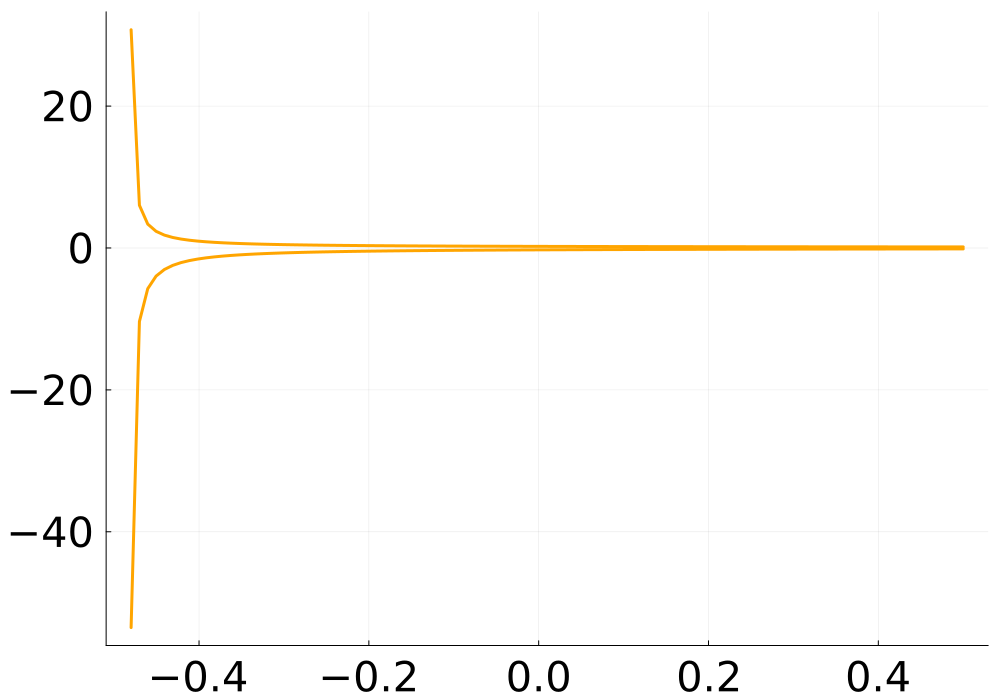

In [14]:
#pyplot()
al = -0.48:0.0098:0.5
plot_1 = plot(size=(1000,700),xtickfont=font(28), legend = false, 
    ytickfont=font(28),xguidefontsize=32,yguidefontsize=32,legendfont=font(26))
plot!(plot_1,al,x21, color="orange",linewidth=3)
plot!(plot_1,al,x22, color="orange",linewidth=3)
#al=[-0.48:0.98/19:0.5;]
#for i=5:length(res)
    #scatter!([al[i]],[res[i][1][2][1][1][1]])
    #scatter!([al[i]],[res[i][1][2][1][1][2]])
#end
#scatter!(plot_1,al,x22, color="orange",linewidth=3)
#display(plot_1)

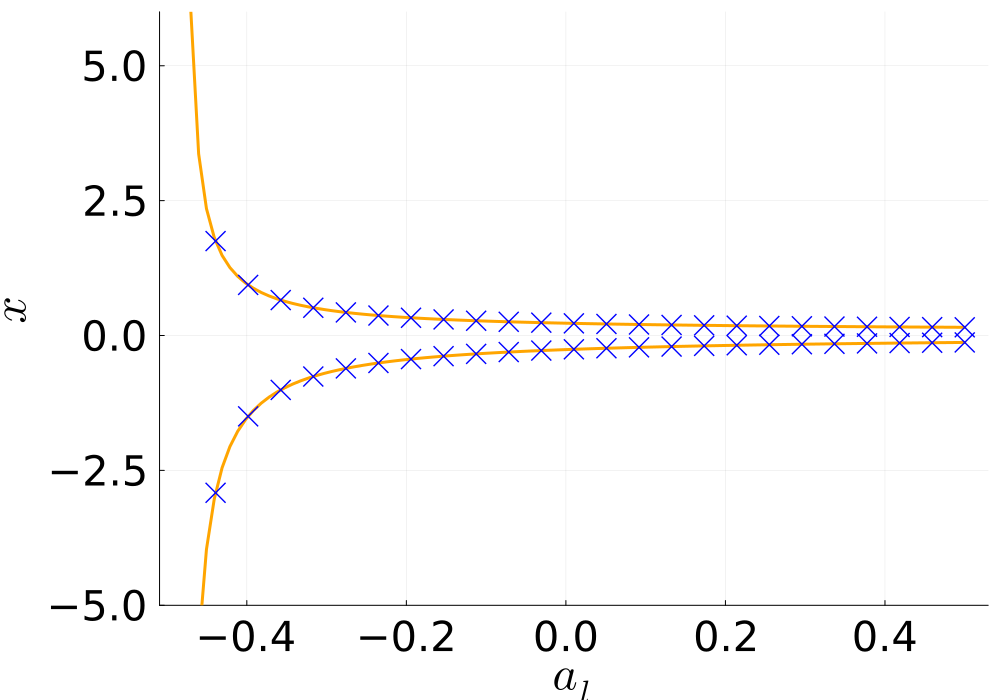

In [15]:
using LaTeXStrings
al=[-0.48:0.98/24:0.5;]
for i=1:length(res)
    if res[i][1][2][1][2][1]<0
        scatter!([al[i]],[res[i][1][2][1][2][1]],markershape=:X,markersize=10,color="blue")
        scatter!([al[i]],[res[i][1][2][1][2][2]],markershape=:X,markersize=10,color="blue")
    else 
        scatter!([al[i]],[res[i][1][2][1][1][1]],markershape=:X,markersize=10,color="blue")
        scatter!([al[i]],[res[i][1][2][1][1][2]],markershape=:X,markersize=10,color="blue",ylim=(-5,6)) 
    end
    
end
#catter!(plot_1,al,x22, color="orange",linewidth=3)
xlabel!(L"a_l")
ylabel!(L"x")
#savefig(plot_1,"state space 1 no legend.png")
display(plot_1)

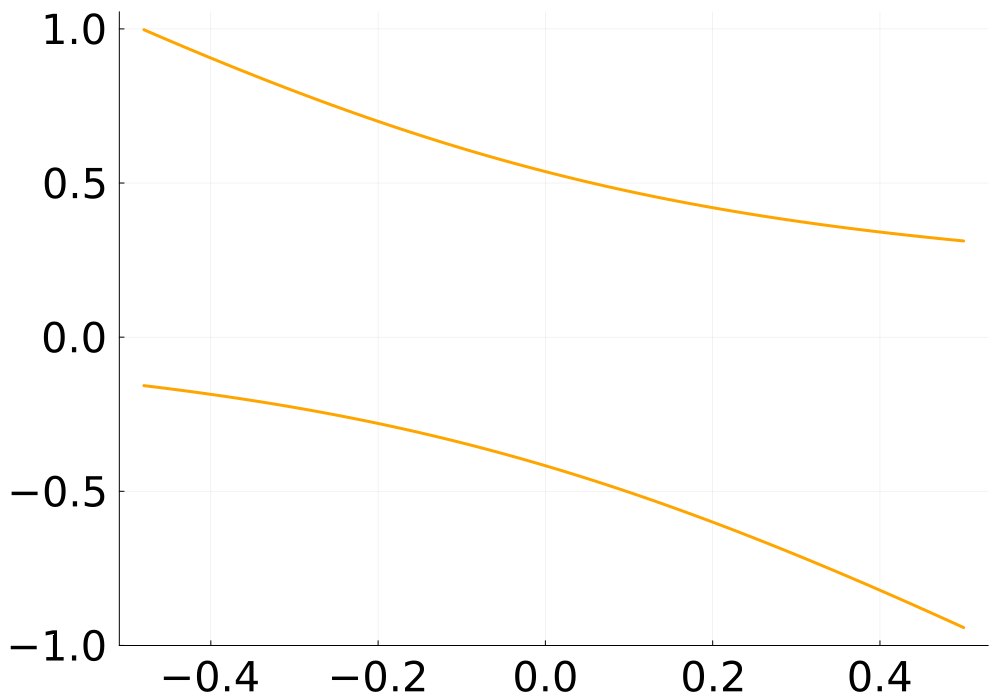

In [16]:
ar = ones(101)*-1.5
al = -0.48:0.0098:0.5
J11 = al.*ar.+br.*c
J12 = al.*c.+c.*d
J21 = ar.*bl.+br.*d
J22 = (d^2 .+bl.*c) .* ones(101)

J_1=[]
J_2=[]
for i in eachindex(al)
    J_al = [J11[i] J12[i];J21[i] J22[i]]
    
    J_1_al,J_2_al = eigvals(J_al) 
    
    # manually sort eigenvalues into  lamda 1 and lambda 2
    if J_1_al>0
        push!(J_1,J_1_al)
        push!(J_2,J_2_al)
    else
        push!(J_1,J_1_al)
        push!(J_2,J_2_al)
    end
end

                                    
plot_2 = plot(size=(1000,700),xtickfont=font(28), legend = false, 
    ytickfont=font(28),xguidefontsize=32,yguidefontsize=32,legendfont=font(26))
plot!(plot_2,al,J_1, color="orange", label=r"analytical eigenvalue 1",linewidth=3)
plot!(plot_2,al,J_2, color="orange", label=r"analytical ceigenvalue 2",linewidth=3)


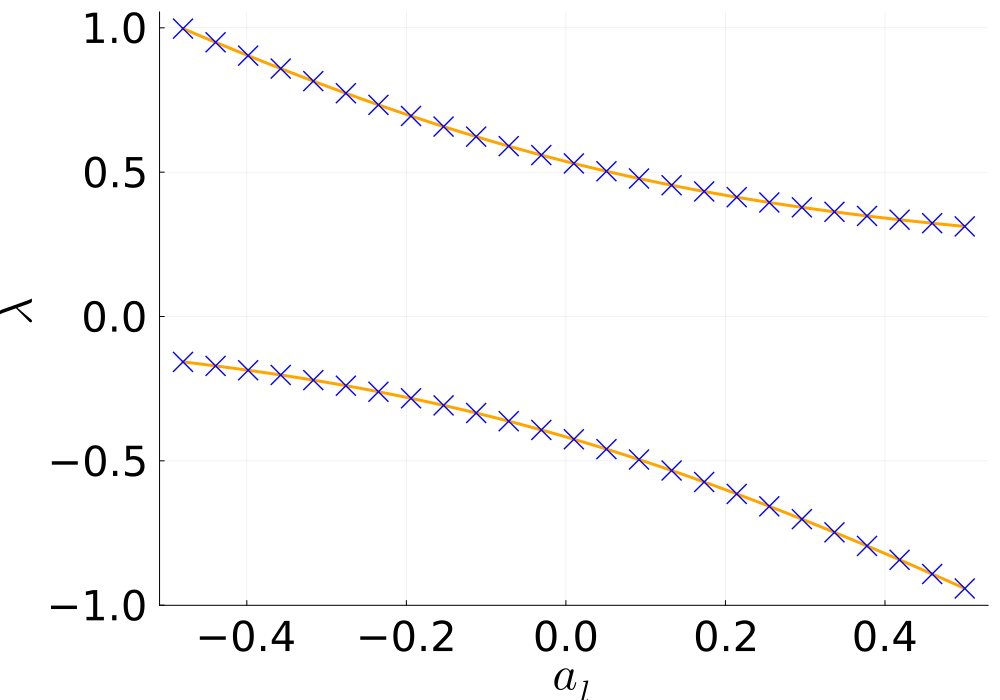

In [17]:
al=[-0.48:0.98/24:0.5;]
for i=1:length(res)
    if res[i][1][2][1][2][1]<0
        scatter!([al[i]],[res[i][2][2][1][1]],markershape=:X,markersize=10,color="blue")
        scatter!([al[i]],[res[i][2][2][1][2]],markershape=:X,markersize=10,color="blue")
    else 
        scatter!([al[i]],[res[i][2][2][1][1]],markershape=:X,markersize=10,color="blue")
        scatter!([al[i]],[res[i][2][2][1][2]],markershape=:X,markersize=10,color="blue") 
    end
    
end

xlabel!(L"a_l")
ylabel!(L"\lambda")
savefig(plot_2,"eigenvalues 1 no legend.png")
display(plot_2)